# Определение возраста покупателей
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя. 

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека, и получить итоговую метрику **MAE меньше 8**. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
# импортирование библиотек и методов 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Загрузка данных
В нашем распоряжении 7591 размеченная фотография. Такое количество данных достаточно для обучения модели.

In [8]:
# загрузка датасета
data = pd.read_csv('faces_labels.csv', index_col=0)

# объект ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)

# считывание изображений 
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=data, directory=r'\computer_vision',
                                                   x_col='file_name', y_col='real_age', target_size=(224, 224),
                                                   batch_size=32, class_mode='raw', seed=12345)
# просмотр датасета
display(data.head())
display('Количество наблюдений: ' + str(data.shape[0]))

Found 0 validated image filenames.


C:\Users\whois\anaconda3\envs\ds_practicum_env\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 7591 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


'Количество наблюдений: 7591'

## Распределение возраста
По статистическим величинам и гистограмме можно сказать:
* Основное количество наблюдений приходится на возрастную группу от **20 до 41 года**.
* **Имеется аномалия:** небольшой всплеск наблюдений в промежутке от 1 до 3 лет.
* **Данные распределены нормально**, по мере удаления от основной группы (20-40 лет) количество наблюдений падает.

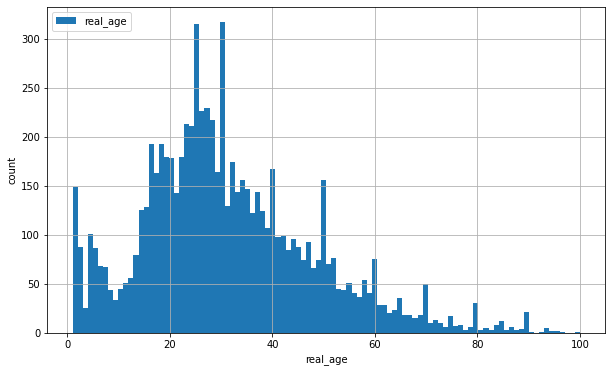

In [4]:
# распределение возраста в выборке
ax = data['real_age'].plot(kind='hist', bins=100, figsize=(10, 6), grid=True)
ax.set_xlabel('real_age')
ax.set_ylabel('count')
legend = ax.legend(loc='upper left')
plt.show()

In [5]:
# статистические величины распределения
display(data['real_age'].describe())

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

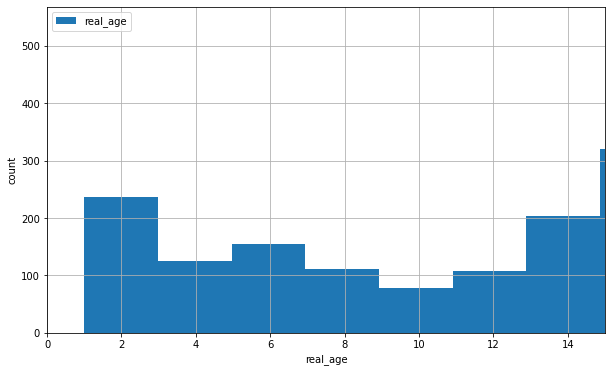

In [6]:
# распределение возраста в промежутке от 0 до 15 лет
ax = data['real_age'].plot(kind='hist', bins=50, xlim=(0, 15), figsize=(10, 6), grid=True)
ax.set_xlabel('real_age')
ax.set_ylabel('count')
legend = ax.legend(loc='upper left')
plt.show()

## Устройство датасета
По фотографиям видно, что анализ возраста нейронной сетью будет производится по лицу, так как они на фотографиях центрированы.

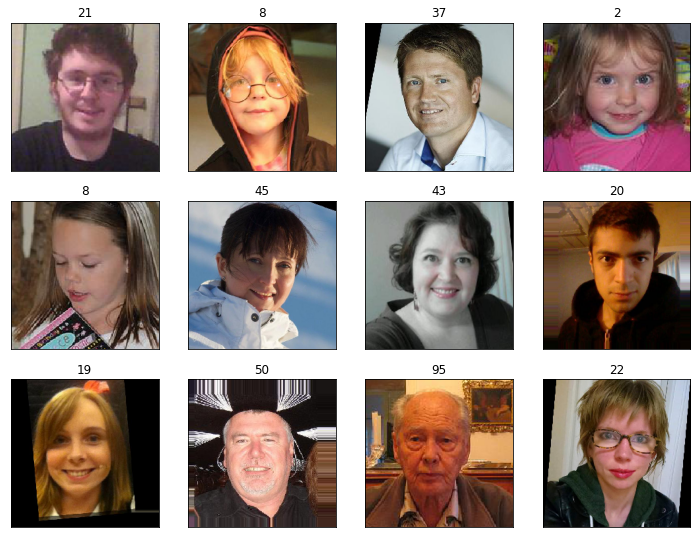

In [11]:
# формирование признака и целевого признака
features, target = next(train_gen_flow)

# вывод 12-ти фотографий
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Вывод
* Учитывая, что необходимо предсказывать возраст покупателя, можно сделать вывод, что перед нами стоит задача регрессии.
* Наиболее точно модель будет предсказывать возраст из группы 20-40 лет.
* Анализ возраста происходит по лицу.
* В нашем распоряжении не такой большой датасет, поэтому предпочтительнее использовать нейронную сеть ResNet50 предобученную на наборе данных ImageNet.
* В наборе присутствуют черно-белые фотографии.
* Размер у фотографий разный.
* На фотографиях лица центрированы, поэтому их не нужно поворачивать. Можно отразить фотографии по горизонтали, это увеличит обучающую выборку в два раза.

## Обучение модели


Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import AvgPool2D, Conv2D, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.25, horizontal_flip=True)
    dataframe = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(directory=path + 'final_files/',
        dataframe=dataframe, target_size=(224, 224), batch_size=32, class_mode='raw', subset='training',
        x_col='file_name', y_col='real_age', seed=12345)    
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.25)
    dataframe = pd.read_csv(path + 'labels.csv')
    test_datagen_flow = test_datagen.flow_from_dataframe(directory=path + 'final_files/',
        dataframe=dataframe, target_size=(224, 224), batch_size=32, class_mode='raw', subset='validation',
        x_col='file_name', y_col='real_age', seed=12345)    
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr=0.0005)
    backbone = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss=MeanSquaredError(),
                  metrics=[MeanAbsoluteError()])
    return model

def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=25,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/25
178/178 - 61s - loss: 195.4775 - mean_absolute_error: 10.3293 - val_loss: 506.3454 - val_mean_absolute_error: 17.4385
Epoch 2/25
178/178 - 37s - loss: 100.3619 - mean_absolute_error: 7.6390 - val_loss: 319.6308 - val_mean_absolute_error: 13.2727
Epoch 3/25
178/178 - 37s - loss: 59.4824 - mean_absolute_error: 5.8843 - val_loss: 376.1338 - val_mean_absolute_error: 14.4038
Epoch 4/25
178/178 - 37s - loss: 39.8468 - mean_absolute_error: 4.8474 - val_loss: 378.3751 - val_mean_absolute_error: 15.8034
Epoch 5/25
178/178 - 37s - loss: 31.1157 - mean_absolute_error: 4.2952 - val_loss: 111.9747 - val_mean_absolute_error: 8.0951
Epoch 6/25
178/178 - 37s - loss: 21.6016 - mean_absolute_error: 3.5465 - val_loss: 81.2537 - val_mean_absolute_error: 6.7086
Epoch 7/25
178/178 - 39s - loss: 17.1174 - mean_absolute_error: 3.1625 - val_loss: 82.9508 - val_mean_absolute_error: 6.7152
Epoch 8/25
178/178 - 43s - loss: 13.2887 - mean_absolute_error: 2.7877 - val_loss: 69.5738 - val_mean_absolute_error: 6.2527
Epoch 9/25
178/178 - 63s - loss: 10.0045 - mean_absolute_error: 2.4092 - val_loss: 76.0454 - val_mean_absolute_error: 6.7605
Epoch 10/25
178/178 - 65s - loss: 8.5928 - mean_absolute_error: 2.2281 - val_loss: 75.6555 - val_mean_absolute_error: 6.8088
Epoch 11/25
178/178 - 57s - loss: 7.5700 - mean_absolute_error: 2.0960 - val_loss: 66.3821 - val_mean_absolute_error: 6.1720
Epoch 12/25
178/178 - 55s - loss: 6.8249 - mean_absolute_error: 1.9770 - val_loss: 76.4438 - val_mean_absolute_error: 6.4647
Epoch 13/25
178/178 - 70s - loss: 6.3774 - mean_absolute_error: 1.9300 - val_loss: 72.8917 - val_mean_absolute_error: 6.5409
Epoch 14/25
178/178 - 71s - loss: 6.8945 - mean_absolute_error: 2.0042 - val_loss: 70.1914 - val_mean_absolute_error: 6.3651
Epoch 15/25
178/178 - 58s - loss: 7.8115 - mean_absolute_error: 2.1463 - val_loss: 74.5430 - val_mean_absolute_error: 6.5413
Epoch 16/25
178/178 - 69s - loss: 8.0922 - mean_absolute_error: 2.1794 - val_loss: 80.3427 - val_mean_absolute_error: 6.9786
Epoch 17/25
178/178 - 47s - loss: 9.5608 - mean_absolute_error: 2.3520 - val_loss: 81.8476 - val_mean_absolute_error: 6.9906
Epoch 18/25
178/178 - 48s - loss: 10.3356 - mean_absolute_error: 2.4788 - val_loss: 136.8780 - val_mean_absolute_error: 8.4784
Epoch 19/25
178/178 - 52s - loss: 15.7350 - mean_absolute_error: 3.0224 - val_loss: 171.1215 - val_mean_absolute_error: 10.1017
Epoch 20/25
178/178 - 38s - loss: 58.5483 - mean_absolute_error: 5.5911 - val_loss: 295.4663 - val_mean_absolute_error: 12.9186
Epoch 21/25
178/178 - 38s - loss: 65.5990 - mean_absolute_error: 6.1062 - val_loss: 111.8092 - val_mean_absolute_error: 8.0489
Epoch 22/25
178/178 - 49s - loss: 23.9050 - mean_absolute_error: 3.7411 - val_loss: 93.1044 - val_mean_absolute_error: 7.1263
Epoch 23/25
178/178 - 49s - loss: 9.5798 - mean_absolute_error: 2.3749 - val_loss: 73.9718 - val_mean_absolute_error: 6.5920
Epoch 24/25
178/178 - 37s - loss: 4.2562 - mean_absolute_error: 1.5891 - val_loss: 70.7819 - val_mean_absolute_error: 6.3420
Epoch 25/25
178/178 - 39s - loss: 2.3250 - mean_absolute_error: 1.1659 - val_loss: 69.4373 - val_mean_absolute_error: 6.3763
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 69.4373 - mean_absolute_error: 6.3763
Test MAE: 6.3763

```

## Анализ обученной модели

Использованная модель и ее параметры:
* Добавлена аугментация, а именно отражение по горизонтали, это увеличило обучающую выборку в два раза.
* Костяк модели: ResNet50 обученная на наборе ImageNet с удаленным выходным слоем. 
* В качестве алгоритма оптимизации выбран Adam с шагом 0.0005 для наибольшей точности.
* Активатор выходного слоя: ReLU, так как положительные числа он не меняет, а отрицательные приводит к нулю.
* Выбранная функция потерь: MSE, модели с ней обучаются быстрее, чем с MAE.
* Целевая метрика: MAE, что соответствует задаче.

Вывод:
* Обучение длилось около 20-ти минут, **итоговая MAE** на тестовой выборке соответствует задаче (менее 8): **6.3763**.
* Ввиду итоговой ошибки МАЕ, полученная **модель позволит решить поставленную бизнесом задачу**, а именно:
 * Рекомендация товаров покупателям, основанная на их возрастной группе.
* Задачу: контроль добросовестности кассиров при продаже алкоголя, решить моделью не получится из-за высокой ошибки относительно данного запроса. 